Exploring data provided by RELAB 

Documentation available: http://www.planetary.brown.edu/relabdata/catalogues/Catalogue_README.html

In [ ]:
import pandas as pd
import numpy as np
import math

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
#Pull down data 

data_dir = "../RelabDB2018Dec31/data/"

file_name = "../RelabDB2018Dec31/catalogues/Minerals.xls"
minerals = pd.read_excel(file_name)

file_name = "../RelabDB2018Dec31/catalogues/Spectra_Catalogue.xls"
Spectra_Catalogue = pd.read_excel(file_name)
Spectra_Catalogue['SampleID'] = Spectra_Catalogue['SampleID'].str.strip()

file_name = "../RelabDB2018Dec31/catalogues/Sample_Catalogue.xls"
Sample_Catalogue = pd.read_excel(file_name)
Sample_Catalogue['SampleID'] = Sample_Catalogue['SampleID'].str.strip()


file_name = "../RelabDB2018Dec31/catalogues/Chem_Analyses.xls"
Chem_Analyses = pd.read_excel(file_name)


file_name = "../RelabDB2018Dec31/catalogues/Modal_Mineralogy.xls"
Modal_Mineralogy = pd.read_excel(file_name)
Modal_Mineralogy['SampleID'] = Modal_Mineralogy['Sample ID'].str.strip()


In [ ]:
sample_spectra = pd.merge(left=Spectra_Catalogue,
                        right=Sample_Catalogue, 
                        on = 'SampleID')

# All endmember samples are in 'sample_spectra_mixtures' except for pure olivine, pure_olivine_sid = "C1PO17" 
sample_spectra_mixtures = pd.merge(left=sample_spectra,
                        right=Modal_Mineralogy, 
                        on = 'SampleID')

In [ ]:
# Spectrum IDs
pure_olivine_sid = "C1PO17" # Does not exist in ModalMineralogy
pure_enstatite_sid = "C2PE12"
pure_anorthite_sid = "C1PA12"

sids_n = {pure_olivine_sid : 1.66,
         pure_enstatite_sid: 1.66,
         pure_anorthite_sid: 1.57}

pure = [pure_olivine_sid, pure_enstatite_sid, pure_anorthite_sid]

olivine_enstatite_mix_sid5 = "CBXO15"
olivine_enstatite_mix_sid6 = "CBXO16"
olivine_enstatite_mix_sid7 = "CBXO17"
olivine_enstatite_mix_sid8 = "CBXO18"
olivine_enstatite_mix_sid9 = "CBXO19"

olivine_anorthite_mix_sid0 = "CBXO20"
olivine_anorthite_mix_sid1 = "CBXO21"
olivine_anorthite_mix_sid2 = "CBXO22"
olivine_anorthite_mix_sid3 = "CBXO23"
olivine_anorthite_mix_sid4 = "CBXO24"

enstatite_anorthite_mix_sid1 = "CBXA01"
enstatite_anorthite_mix_sid2 = "CBXA02"
enstatite_anorthite_mix_sid3 = "CBXA03"
enstatite_anorthite_mix_sid4 = "CBXA04"
enstatite_anorthite_mix_sid5 = "CBXA05"


ternary_mix_sid0 = "CMXO30"
ternary_mix_sid1 = "CMXO31"
ternary_mix_sid2 = "CMXO32"
ternary_mix_sid3 = "CMXO33"
ternary_mix_sid4 = "CMXO34"
ternary_mix_sid5 = "CMXO35"
ternary_mix_sid6 = "CMXO36"

mixtures = [olivine_enstatite_mix_sid5, 
            olivine_enstatite_mix_sid6, 
            olivine_enstatite_mix_sid7, 
            olivine_enstatite_mix_sid8, 
            olivine_enstatite_mix_sid9,
            olivine_anorthite_mix_sid0,
            olivine_anorthite_mix_sid1,
            olivine_anorthite_mix_sid2,
            olivine_anorthite_mix_sid3,
            olivine_anorthite_mix_sid4,
            enstatite_anorthite_mix_sid1,
            enstatite_anorthite_mix_sid2,
            enstatite_anorthite_mix_sid3,
            enstatite_anorthite_mix_sid4,
            enstatite_anorthite_mix_sid5,
            ternary_mix_sid0,
            ternary_mix_sid1,
            ternary_mix_sid2,
            ternary_mix_sid3,
            ternary_mix_sid4,
            ternary_mix_sid5,
            ternary_mix_sid6]
all_sids = mixtures + pure


In [ ]:
olivine_k, best_rmse  = get_best_k(pure_olivine_sid, sample_spectra)
print("Best k is : " + str(olivine_k) + " with RMSE: " + str(best_rmse))

In [ ]:
def get_reflectance_rmse(sid, sample_spectra, k, D):
    sample_row = sample_spectra[sample_spectra['SpectrumID']==sid]
    # source_angle : incidence angle in degrees
    source_angle = sample_row["SourceAngle"].values[0] 
    mu_0 = get_cosine(source_angle)

    # detect_angle emission/emergence angle in degrees
    detect_angle = sample_row["DetectAngle"].values[0] 
    mu = get_cosine(detect_angle)

    wavelengths = get_wavelengths(sid, sample_spectra)

    n = sids_n[sid]
   
    
    w = get_w_hapke_estimate(n, k, D, wavelengths)

    # Calculated estimated reflectance
    r_e = get_reflectance_hapke_estimate(mu, mu_0, w)
    
    # Get actual reflectance from data
    r = get_reflectance_spectra(sid, sample_spectra)
    
    
    return get_rmse(r, r_e)

def get_D_average_rmse(sid, sample_spectra, k):
    d_min, d_max = get_grain_sizes(sid, sample_spectra)
    # D = d_min
    grain_sizes = list(range(int(d_min), int(d_max)))
    rmses = []
    for D in grain_sizes:
        rmse = get_reflectance_rmse(sid, sample_spectra, k, D)
        rmses.append(rmse)
    return sum(rmses)/len(rmses)


def get_best_k(sid, sample_spectra):
    # 100,000 values from 10^-14 to 1, in log space
    k_space = np.logspace(-14,-1,1e5)
    min_rmse = 20000
    min_k = None
    for k in k_space:
        rmse = get_D_average_rmse(sid, sample_spectra, k)
        if rmse < min_rmse:
            min_k = k
            min_rmse = rmse
    if k is None:
        print("Could not estimate k.")
    return min_k, min_rmse

In [ ]:
def get_rmse(a, b):
    """
    Get RMSE between 2 Numpy arrays
    """
    return np.sqrt(np.mean((a-b)**2))

def get_w_hapke_estimate(n, k, D, wavelengths):
    """
    Get w, SSA, as estimated by the Hapke model
    :param k: Numpy array, imaginary index of refraction
    :param n: scalar, real index of refraction
    :param D: scalar, grain size
    :param wavelengths: Numpy array, Wavelengths (lambda values)
    """
    Se = get_S_e(k, n)
    Si = get_S_i(n)
    brackets_D = get_brackets_D(n, D)
    Theta = get_Theta(k, wavelengths, brackets_D)
    
    return Se + ( 1- Se)*( (1-Si)/ (1-Si*Theta))*Theta
    
def get_brackets_D(n, D):
    """
    Get the mean free path
    :param n: scalar, real index of refraction
    :param D: scalar, grain size
    """
    return (2/3) * ((n**2) - (1/n)*( (n**2)-1 )**(3/2) ) * D
    
def get_S_e(k, n):
    """
    Get S_e, surface reflection coefficient S_e for externally incident light
    :param k: Numpy array 
    :param n: scalar, real index of refraction
    """
    return ((((n-1)**2) + k**2) / (((n+1)**2) + k**2)) + 0.05
        

def get_S_i(n):
    """
    Get S_i, reflection coefficient for internally scattered light
    :param n: scalar, real index of refraction
    """
    return 1.014 - (4/ (n * ((n+1)**2) ))


def get_Theta(k, wavelengths, brackets_D):
    """
    :param k: scalar, k value for this wavelength
    :param wavelengths: Numpy array, wavelength values (lambda)
    :param brackets_D: scalar, <D>
    :return: Numpy array
    """
    alpha = get_alpha(k, wavelengths)
    return np.exp(- np.sqrt( (alpha**2)*brackets_D ))

def get_alpha(k, wavelengths):
    """
    Gets internal absorption coefficient
    :param k: scalar, k value for this wavelength
    :param wavelengths: Numpy array, wavelength values (lambda)
    :return: Numpy array
    """
    return (4* math.pi * k)/wavelengths

Compute reflectance of SSA using Equation 8 

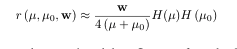



Chandrasekhar integral function

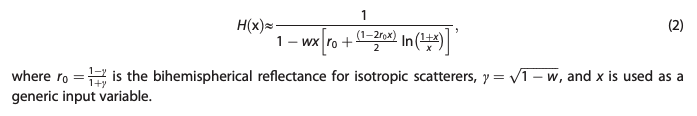

In [ ]:
def get_reflectance_hapke_estimate(mu, mu_0, w):
    """
    Gets reflectance r(mu, mu_0, w)
    :param mu: cosine of detect angle
    :param mu_0: cosine of source angle
    :param w: Numpy array of SSA 
    """
    d = 4 * (mu + mu_0)
    return (w/d) * get_H(mu, w) * get_H(mu_0, w)

def get_H(x, w):
    """
    get output of Chandrasekhar integral function given x and SSA w
    :param x: scalar value 
    :param w: Numpy array of SSA 
    """
    # Solve for gamma
    gamma = (1-w) ** (1/2)
    # Solve for r_0
    r_0 = (1-gamma) / (1+gamma)
    
    # Inner fraction
    f = (1 - (2*x*r_0))/2
    
    # Inner [r_0 + fraction * log]
    nf = r_0 + (f * math.log((1+x)/x))
    
    # Denominator
    d = 1-((w*x)*nf) 
    return 1/d
    
    
def get_cosine(x):
    """
    Gets cosine of x 
    :param x: in degrees
    """
    return math.cos(math.radians(x))  

In [ ]:
def get_grain_sizes(spectrum_id, sample_spectra):
    """
    Get range of grain sizes 
    :param spectrum_id: SpectrumID in dataset to look up
    :param sample_spectra:  Merge of Spectra_Catalogue and Sample_Catalogue
    """
    s = sample_spectra[sample_spectra['SpectrumID'] == spectrum_id]
    min_grain_size = s['MinSize'].values[0]
    max_grain_size = s['MaxSize'].values[0]
    return min_grain_size, max_grain_size


def get_wavelengths(spectrum_id, sample_spectra):
    r_data = get_reflectance_data(spectrum_id, sample_spectra)
    return r_data['Wavelength(micron)'].values

def get_reflectance_spectra(spectrum_id, sample_spectra):
    r_data = get_reflectance_data(spectrum_id, sample_spectra)
    return r_data['Reflectance'].values

def get_reflectance_data(spectrum_id, sample_spectra):
    """
    Returns spectral reflectance for the passed-in spectrum ID
    :param spectrum_id: SpectrumID in dataset to look up
    :param sample_spectra:  Merge of Spectra_Catalogue and Sample_Catalogue
    :return reflectance_df: Pandas DataFrame with 2 columns [Wavelength(micron), Reflectance]
    """
    pi = sample_spectra[sample_spectra['SpectrumID'] == spectrum_id]["PI"].values[0]
    sampleid = sample_spectra[sample_spectra['SpectrumID'] == spectrum_id]["SampleID"].values[0]

    pi = pi.lower()
    pre_sampleid = sampleid[0:2].lower()
    spectrum_id = spectrum_id.lower()
    file_name = data_dir + pi + "/" + pre_sampleid + "/" + spectrum_id + ".txt"

    reflectance_df = pd.read_csv(file_name, sep="\t", header=0,skiprows =1)
    return reflectance_df